# Predict POS with an HMM

```yaml
Course:   DS 5001
Module:   04 Lab
Topic:    Predict POS with an HMM
Author:   R.C. Alvarado
Date:     14 February 2022 (revised and improved)
```

**Purpose**: Demonstrate Hidden Markov Model applied to POS detection, including the Viterbi algorithm by hand. 

# Set Up

In [1]:
import pandas as pd
import numpy as np
import nltk
import re

In [2]:
import configparser

In [3]:
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [4]:
data_prefix = 'austen-melville'

In [5]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
SENT = OHCO[:4]
colors = "YlGnBu"

# Get Annotated `TOKEN` Table

We use the `CORPUS` table from our previous exercise.

In [6]:
TOKEN = pd.read_csv(f"{output_dir}/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [7]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     24       0        6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  
book_id chap_id para_num sent_num token_num            
105     1       1        0        0                NN  
                                  1                NN  
                                  2                NN  
                                  3                IN  
                                  4                NN  
...                                               ...  
34970   114     24       0        6                DT  
                                  7                NN  
                                  8                IN  
                                  9                NN  
                                  10               NN  

[1940037 rows x 5 columns]

# Create Table of POS Tags 

We create a table rrom the Penn Treebank Project list of part-of-speech tags.

## Grab UPenn Codes

We get a text version of the UPenn Codes, or tag set, by calling `nltk.help.upenn_tagset()`. The extra information can be used later in visualizations, etc.

In [8]:
POS = pd.read_csv(f'{data_home}/misc/upenn_tagset.txt', sep='\t', names=['pos_code','def'])
POS = POS[POS.pos_code.str.match(r'^\w')].set_index('pos_code') # Keep only letter codes

In [9]:
POS

,def
pos_code,
CC,"conjunction, coordinating"
CD,"numeral, cardinal"
DT,determiner
EX,existential there
FW,foreign word
IN,"preposition or conjunction, subordinating"
JJ,"adjective or numeral, ordinal"
JJR,"adjective, comparative"
JJS,"adjective, superlative"


## Add value counts

In [10]:
POS['n'] = TOKEN.pos.value_counts().to_frame().sort_index()
POS['n'] = POS['n'].fillna(0).astype('int')

In [11]:
POS.sort_values('n', ascending=False)

,def,n
pos_code,,
NN,"noun, common, singular or mass",361020
IN,"preposition or conjunction, subordinating",247851
DT,determiner,191697
JJ,"adjective or numeral, ordinal",146688
PRP,"pronoun, personal",110190
RB,adverb,107894
VBD,"verb, past tense",97086
NNP,"noun, proper, singular",93347
VB,"verb, base form",85844


## Create `POS_GROUP` table

We want a simplified list of grammatical categories. We use the first two letters of each code name as our group.

In [12]:
# Add pos_group feature to POS and TOKEN
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
# TOKEN['pos_group'] = TOKEN.pos.str[:2]

In [13]:
# Generate new table from it
POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

In [14]:
POS_GROUP.sort_values('i').style.background_gradient(cmap=colors)

,n,def,p,i,h
pos_group,,,,,
NN,509616,"noun, common, singular or mass; noun, proper, singular; noun, proper, plural; noun, common, plural",0.262726,1.928371,0.506633
VB,336886,"verb, base form; verb, past tense; verb, present participle or gerund; verb, past participle; verb, present tense, not 3rd person singular; verb, present tense, 3rd person singular",0.173677,2.525521,0.438625
IN,247851,"preposition or conjunction, subordinating",0.127776,2.968309,0.379279
DT,191697,determiner,0.098827,3.338954,0.329978
PR,166335,"pronoun, personal; pronoun, possessive",0.085752,3.543690,0.303878
JJ,156242,"adjective or numeral, ordinal; adjective, comparative; adjective, superlative",0.080548,3.633999,0.292713
RB,113196,"adverb; adverb, comparative; adverb, superlative",0.058357,4.098959,0.239202
CC,77327,"conjunction, coordinating",0.039865,4.648738,0.185321
TO,52666,"""to"" as preposition or infinitive marker",0.027151,5.202838,0.141264


## Save

In [15]:
POS.to_csv(f"{output_dir}/{data_prefix}-POS.csv")
POS_GROUP.to_csv(f"{output_dir}/{data_prefix}-POS_GROUP.csv")

# Extract Model from `TOKEN`

In [16]:
TOKEN = TOKEN.join(POS, on="pos_group", rsuffix='_y').dropna()

In [17]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     24       0        6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  \
book_id chap_id para_num sent_num token_num             
105     1       1        0        0                NN   
                                  1                NN   
                                  2                NN   
                                  3                IN   
                                  4                NN   
...                                               ...   
34970   114     24       0        6                DT   
                                  7                NN   
                                  8                IN   
                                  9                NN   
                                  10               NN   

                                                                                    def  \
book_id chap_id para_num sent_num token_num                                               
105     1       1        0        0                      noun, common, singular or mass   
                                  1                      noun, common, singular or mass   
                                  2                      noun, common, singular or mass   
                                  3           preposition or conjunction, subordinating   
                                  4                      noun, common, singular or mass   
...                                                                                 ...   
34970   114     24       0        6                                          determiner   
                                  7                      noun, common, singular or mass   
                                  8           preposition or conjunction, subordinating   
                                  9                      noun, common, singular or mass   
                                  10                     noun, common, singular or mass   

                                                    n pos_group_y  
book_id chap_id para_num sent_num token_num                        
105     1       1        0      

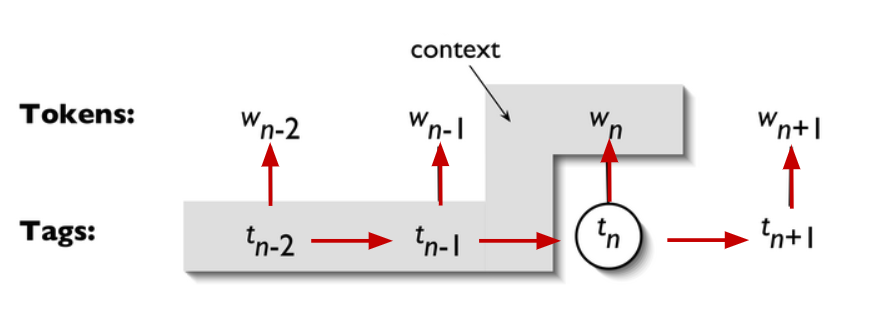
<img src="images/hmm.png" width="750">

## Create Table of $t_n \rightarrow t_{n+1}$ Transissions ($A$)

**Add sentence boundaries to sequence**

Note that we are breaking our data by adding `<s>` as a key, although 
it is not part of the UPenn tagset. We might consider creating a code 
for sentence beginnings or endings, such as the stop tag in Eistenstein 2019.

In [18]:
A = TOKEN[['pos_group']].join(TOKEN[['pos_group']].shift(-1), lsuffix='_x', rsuffix="_y")\
    .value_counts().to_frame('n').sort_index()

In [19]:
A['cp'] = A.n / A.groupby('pos_group_x').n.sum()  # P(y|x)

In [20]:
A

n        cp
pos_group_x pos_group_y                
CC          CC            113  0.001461
            CD           1077  0.013928
            DT           8867  0.114669
            EX            405  0.005237
            FW              1  0.000013
...                       ...       ...
WP          MD           1107  0.109778
            NN           1439  0.142701
            RB            492  0.048790
            TO            111  0.011008
            VB           5462  0.541650

[205 rows x 2 columns]

In [21]:
AM = A.cp.unstack(fill_value=0)

In [22]:
AM.style.background_gradient(axis=None, cmap=colors)

pos_group_y,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,RB,RP,TO,UH,VB,WP
pos_group_x,,,,,,,,,,,,,,,,
CC,0.001461,0.013928,0.114669,0.005237,0.000013,0.106341,0.088779,0.000000,0.025140,0.248645,0.104297,0.000026,0.010320,0.000013,0.272505,0.008626
CD,0.060179,0.016290,0.009200,0.000422,0.000084,0.165007,0.098920,0.000000,0.018653,0.513842,0.018231,0.000169,0.010972,0.000000,0.079338,0.008693
DT,0.001122,0.009807,0.002061,0.000115,0.000303,0.013135,0.248157,0.000000,0.002681,0.656708,0.029082,0.000130,0.001450,0.000005,0.033689,0.001555
EX,0.001958,0.001399,0.025175,0.000000,0.000000,0.020979,0.010629,0.000000,0.093427,0.016503,0.030210,0.000000,0.001399,0.000000,0.798042,0.000280
FW,0.038793,0.019397,0.168103,0.000000,0.056034,0.023707,0.077586,0.000000,0.006466,0.433190,0.062500,0.002155,0.004310,0.000000,0.107759,0.000000
IN,0.003780,0.012378,0.359555,0.002328,0.000444,0.038709,0.095771,0.000000,0.014101,0.321903,0.024934,0.000125,0.010006,0.000000,0.109029,0.006936
JJ,0.049801,0.005267,0.024411,0.000826,0.000416,0.092024,0.069943,0.000000,0.009332,0.629856,0.021793,0.000371,0.034319,0.000077,0.060105,0.001459
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000
MD,0.004695,0.000821,0.011687,0.000066,0.000000,0.013427,0.001248,0.000000,0.000328,0.008076,0.256664,0.000098,0.011983,0.000000,0.690742,0.000164


## Sanity Tests

In [23]:
AM.sum(1)

pos_group_x
CC    1.0
CD    1.0
DT    1.0
EX    1.0
FW    1.0
IN    1.0
JJ    1.0
LS    1.0
MD    1.0
NN    1.0
RB    1.0
RP    1.0
TO    1.0
UH    1.0
VB    1.0
WP    1.0
dtype: float64

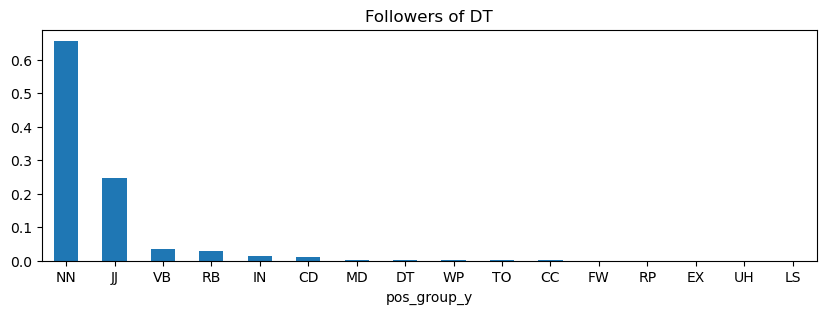

In [24]:
AM.loc['DT'].sort_values(ascending=False).plot.bar(rot=0, title="Followers of DT", figsize=(10,3));

## Create Table of Initial State Probabilities $\Pi$

We get counts of pos tags that appear at the beginnings of sentences. 

Note: since
we took the trouble to create an OHCO index, we don't need to add `<s>` markers
to find out these frequencies.

On the other hand, if we have pads in our Emission table, then we wouldn't need to creat this table at all.

In [25]:
PI = TOKEN.query("token_num == 0").pos_group.value_counts().to_frame('n').sort_index()
PI.index.name = 'pos_group'
PI['cp'] = PI.n / PI.n.sum()

In [26]:
PI

,n,cp
pos_group,,
CC,7231,0.103107
CD,704,0.010038
DT,9390,0.133892
EX,872,0.012434
FW,7,0.000100
IN,9646,0.137543
JJ,4260,0.060743
LS,3,0.000043
MD,403,0.005746


## Make sure $\Pi $ shares sample space with $A$ and $B$

Find out what is missing from PI.\
This will be important below.

In [27]:
for tag in (set(AM.index) - set(PI.index)):
    print(tag)
    PI.loc[tag, ['n', 'cp']] = (0, 0)

RP


In [28]:
PI

,n,cp
pos_group,,
CC,7231.0,0.103107
CD,704.0,0.010038
DT,9390.0,0.133892
EX,872.0,0.012434
FW,7.0,0.000100
IN,9646.0,0.137543
JJ,4260.0,0.060743
LS,3.0,0.000043
MD,403.0,0.005746


## Sanity Test

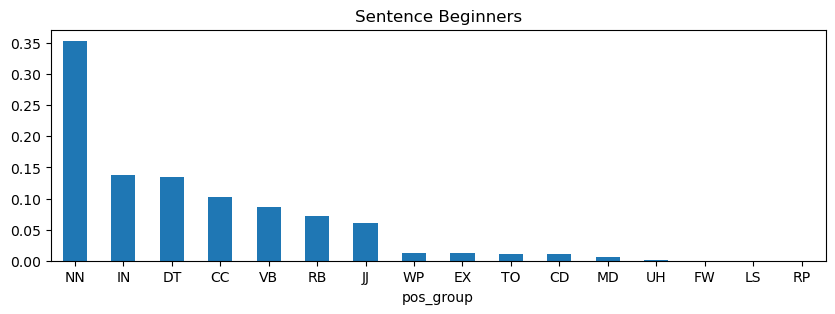

In [29]:
PI.sort_values('cp', ascending=False).cp.plot.bar(rot=0, title="Sentence Beginners", figsize=(10,3));

## Create Table of $t_n \rightarrow o_n$ Emissions ($ B $)

In [30]:
B = TOKEN[['pos_group', 'term_str']].value_counts().to_frame('n').sort_index()
B.index.names = ['pos_group_y', 'term_str']
B['cp'] = B.n / B.groupby('pos_group_y').n.sum()

In [31]:
B.head()

n        cp
pos_group_y term_str                   
CC          acquired        1  0.000013
            ah              1  0.000013
            all             2  0.000026
            altogether      3  0.000039
            and         55766  0.721171

In [32]:
BM = B.cp.unstack(fill_value=0)

In [33]:
BM

term_str,0,1,10,100,1000,10000,10000000,10440,10800,10th,...,zoroaster,zozo,zuma,zur,à,æneas,æniad,æson,æsops,ł20000
pos_group_y,,,,,,,,,,,,,,,,,,,,,
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD,0.000169,0.001350,0.000422,0.000169,0.000169,0.000253,0.000084,0.000084,0.000169,0.000084,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JJ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Sanity Tests

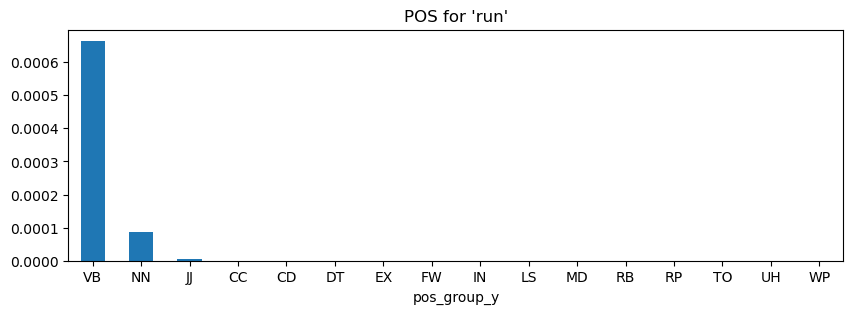

In [34]:
BM["run"].sort_values(ascending=False).plot.bar(rot=0, title="POS for 'run'", figsize=(10,3));

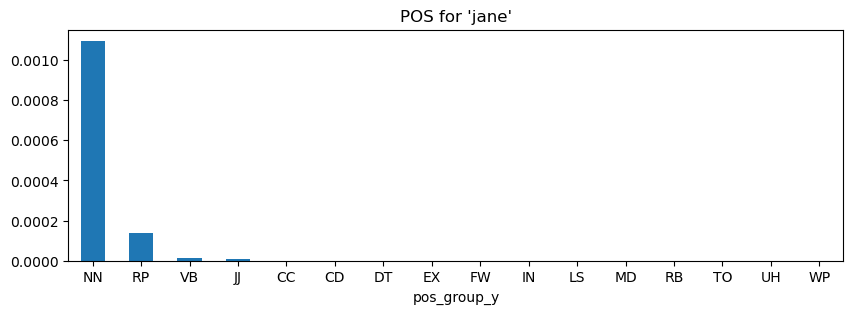

In [35]:
BM["jane"].sort_values(ascending=False).plot.bar(rot=0, title="POS for 'jane'", figsize=(10,3));

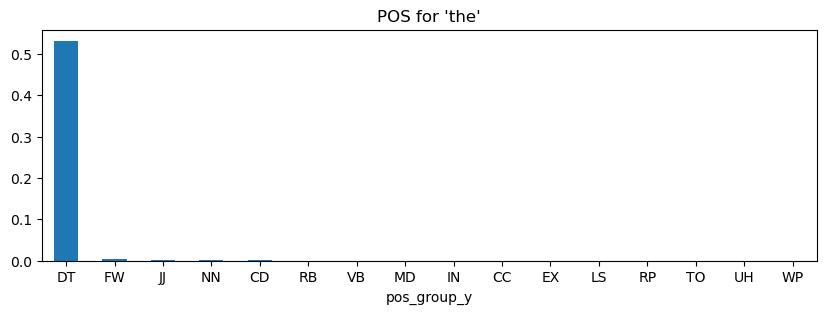

In [36]:
BM["the"].sort_values(ascending=False).plot.bar(rot=0, title="POS for 'the'", figsize=(10,3));

## Put into single model `HMM`

For convenience, bind the tables into signle model table.

Note that a model can be represented as a dataframe.

In [37]:
HMM = pd.concat([AM, PI.cp, BM], keys=['trans','start','emit'], axis=1)

# Prepare Test Data

Import file of raw test sentences.

In [38]:
test_sentences = [s.strip() for s in open(f"{data_home}/misc/test_sentences.txt").readlines()]

Create dataframe of sentences. We will add features here later.

In [39]:
TEST_SENTENCES = pd.DataFrame({'sent_str':test_sentences})
TEST_SENTENCES.index.name = 'sent_id'

In [40]:
TEST_SENTENCES.head()

,sent_str
sent_id,
0,the quick brown fox jumped over the lazy dogs
1,The event had every promise of happiness for h...
2,Mr Weston was a man of unexceptionable charact...
3,but it was a black morning's work for her
4,The want of Miss Taylor would be felt every ho...


Convert sentences to tokens (and terms).

In [41]:
TEST_TOKENS = TEST_SENTENCES.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
TEST_TOKENS.index.names = ['sent_id', 'token_num']
TEST_TOKENS['term_str'] = TEST_TOKENS.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()

In [42]:
TEST_TOKENS.head()

token_str term_str
sent_id token_num                   
0       0               the      the
        1             quick    quick
        2             brown    brown
        3               fox      fox
        4            jumped   jumped

# The Viterbi Algorithm

The Vertibi implements the optimization function ...

<img src="images/formula.png" width="400">

... by means of this procedure: 
<img src="images/viterbi.png" width="750">

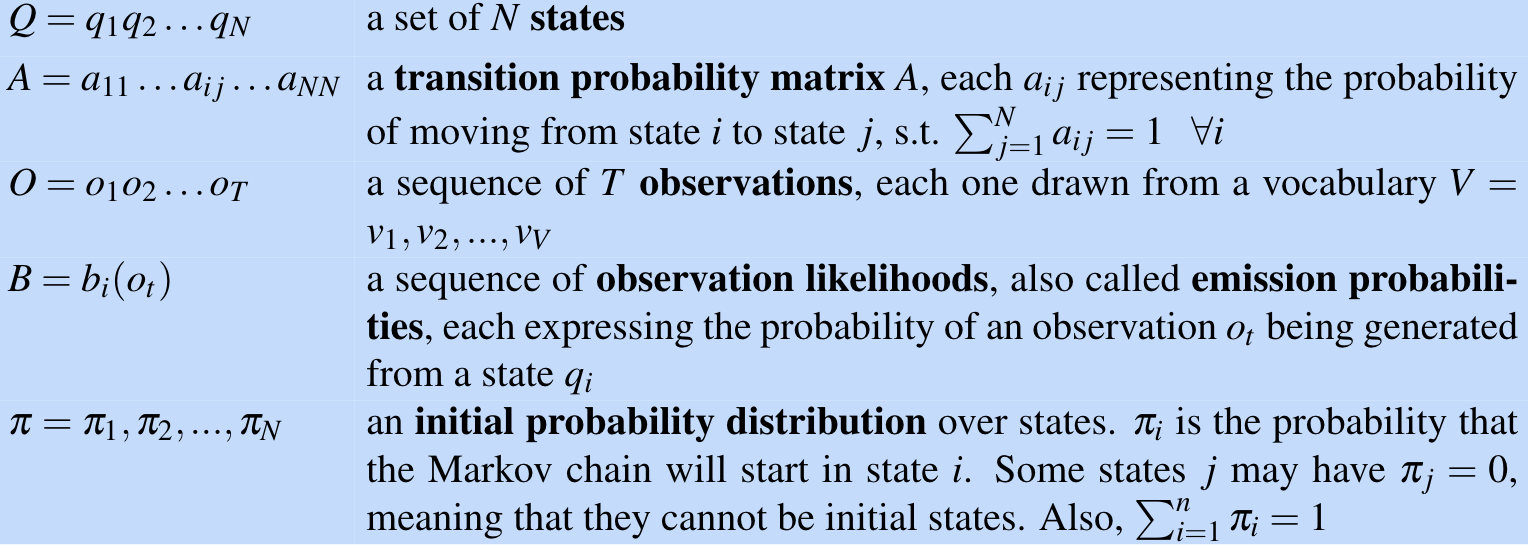

**Translation to NLP use case**:

$Q \rightarrow$ A set of $N$ POS tags.\
$O \rightarrow$ A sequence of $T$ tokens that compose a sentence.\
$A \rightarrow$ POS to POS table $P(q_i|q_{i-1})$.\
$B \rightarrow$ POS to word table $P(w_i|q_i)$.\
$\Pi  \rightarrow$ Probabilites of POS as tag for first token.

In [43]:
# HMM.trans

## Define function

In [44]:
def viterbi(obs, HMM):
    
    # Import model
    states = HMM.index.to_list()
    start_prob = HMM.start.cp
    trans_prob = HMM.trans
    emit_prob = HMM.emit
    
    # Set up Viterbi lattice
    V = pd.DataFrame(np.zeros((len(states), len(obs))), 
                     columns=range(len(obs)), 
                     index=states)
        
    # Initialize the first observation
    V[0] = start_prob * emit_prob[obs[0]]
    
    # Iterate over the remaining observations
    for t, o in enumerate(obs[1:], start=1):
        
        # Simple method -- works OK
        # V[t] = trans_probs[V[t-1].idxmax()] * emit_probs[o]
        
        for s in states:
            try:
                V.loc[s, t] = (V[t-1] * trans_prob[s] * emit_prob.loc[s, o]).max()
            except KeyError:
                V.loc[s, t] = (V[t-1] * trans_prob[s]).max() # Fallback of word is OOV


    return V

* `obs` is a list representing the sequence of observed events $O$ 
* `states` is a list of the hidden states $Q$
* `start_prob` is a pandas Series representing the probability distribution over the states at time 0 $\Pi$
* `trans_prob` is a pandas DataFrame representing the transition probability matrix $A$
* `emit_prob` is a pandas DataFrame representing the emission probability matrix $B$

The function returns a data frame of the Viterbi lattice, which can be used to compute most likely sequence of hidden states that generated the observed events.

## Test with one sentence

In [45]:
test_observations = TEST_TOKENS.loc[TEST_SENTENCES.sample().index[0]].term_str.to_list()

In [46]:
V = viterbi(test_observations, HMM)

In [47]:
pd.concat([pd.Series(test_observations), V.idxmax()], keys=['obs', 'tag'], axis=1).T

,0,1,2,3,4,5,6,7,8
obs,the,quick,brown,fox,jumped,over,the,lazy,dogs
tag,DT,JJ,NN,NN,VB,IN,DT,JJ,NN


In [48]:
for w, k in zip(test_observations, V.idxmax().values):
    print(f"{w}/{k}", end=' ')

the/DT quick/JJ brown/NN fox/NN jumped/VB over/IN the/DT lazy/JJ dogs/NN 

## Diminishing probabilities

Note diminishing probabilities in the lattice.

In [49]:
V.style.background_gradient(cmap=colors, axis=0)

,0,1,2,3,4,5,6,7,8
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DT,0.071221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JJ,0.000089,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NN,0.000467,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Try L1 normalization by column.

In [50]:
VNORM = (V / V.sum()) 

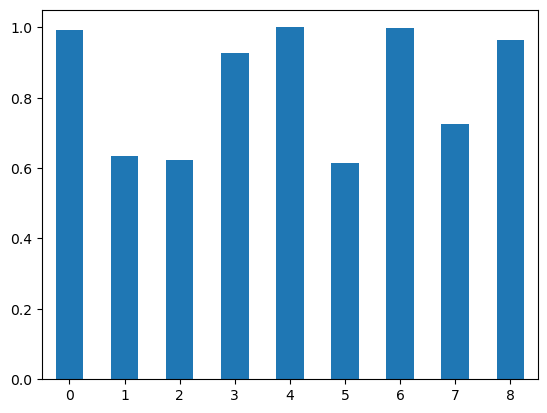

In [51]:
VNORM.max().plot.bar(rot=0);

In [52]:
VNORM.style.background_gradient(cmap=colors)

,0,1,2,3,4,5,6,7,8
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD,0.000083,0.000000,0.000000,0.000000,0.000000,0.000234,0.000038,0.000000,0.000000
DT,0.991817,0.000000,0.000000,0.000000,0.000000,0.000000,0.996897,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000006,0.000000,0.000000,0.000000,0.000000,0.000089,0.000010,0.000000,0.000000
IN,0.000023,0.000344,0.045133,0.000000,0.000000,0.614374,0.000010,0.000000,0.000000
JJ,0.001245,0.634245,0.286688,0.074491,0.000000,0.033388,0.000735,0.724594,0.019738
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000005,0.000000,0.000000,0.000000,0.000000,0.000605,0.000005,0.000000,0.000000
NN,0.006508,0.359801,0.623640,0.925509,0.000000,0.016618,0.002216,0.261291,0.962795


In [53]:
# VNORMI = -np.log2(VNORM)
# VNORMI
# pd.concat([VNORMI.idxmin(), VNORMI.min()], axis=1, keys=['pos','i']).T

# ETA Version

This version uses Pandas, but assumes that data are stored in F2 compliant dataframes, i.e. there is TOKENS table.

All of the resulting data are put where they belong in the model.

## Define the function

In [54]:
def viterbi_eta(sent_tokens, verbose=True):
    """
    - _sent_tokens_ must be a selection from an F1 TOKENS table
    """
    
    # Assumes HMM is in scope
    
    # Import model
    TAGS = HMM.index.to_list()
    PI = HMM.start.cp
    AM = HMM.trans
    BM = HMM.emit
    
    # Extract basic data
    ohco = sent_tokens.index.names # Save for return 
    TOKENS = sent_tokens.reset_index() # Reset index so we can access term_str as a column

    # Define dataframes    
    LATTICE = pd.DataFrame(np.zeros((len(TAGS), len(TOKENS)), 
                dtype='float'), index=TAGS, columns=TOKENS.token_num) 
    LATTICE.index.name = 'pos_group'
    
    # Handle first word (NB: fallback net yet implemented)
    first_word = TOKENS.loc[0].term_str
    LATTICE[0] = PI * BM[first_word]

    # Predict the rest of the sentence
    for t in range(1, len(TOKENS)): # Offset of token
        word = TOKENS.loc[t].term_str
        for s in TAGS: # tag name
            if word not in BM.columns:
                b = 1/len(TAGS) # Fallback probability = equiprobable
            else:
                b = BM.loc[s, word]
            LATTICE.loc[s, t] = (LATTICE[t-1] * AM[s] * b).max()

    # Compute results (no need for backpointer, etc.) and bind to TOKENS
    # LATTICE = LATTICE / LATTICE.sum() # Normalize diminishing probs
    TOKENS['tag'] = LATTICE.idxmax()
    TOKENS['prob'] = LATTICE.max()
    TOKENS['i'] = np.log2(1/TOKENS.prob)
    
    if verbose:
        pp = 2**TOKENS.i.mean().round()
        print(" ".join((TOKENS.term_str + '/' + TOKENS.tag).values), f"({pp})")
    
    # Add index back and return
    TOKENS = TOKENS.set_index(ohco)
    return TOKENS

## Try wiith one sentence

In [55]:
x = TEST_SENTENCES.sample().index[0]
# x = 41
X2 = viterbi_eta(TEST_TOKENS.loc[x])

and/CC many/JJ a/DT long/JJ october/NN and/CC november/NN evening/NN must/MD be/VB struggled/VB through/IN at/IN hartfield/NN (5.902958103587057e+20)


In [56]:
X2

,token_str,term_str,tag,prob,i
token_num,,,,,
0,and,and,CC,7.435782e-02,3.749372
1,many,many,JJ,7.829133e-05,13.640788
2,a,a,DT,4.028349e-07,21.243308
3,long,long,JJ,7.812175e-10,30.253557
4,October,october,NN,2.124247e-14,45.420042
5,and,and,CC,1.685888e-15,49.075413
6,November,november,NN,3.125803e-20,64.794335
7,evening,evening,NN,6.414526e-24,77.044932
8,must,must,MD,2.503133e-26,85.046395


## Try with all sentences

In [57]:
TEST = TEST_TOKENS.groupby('sent_id', group_keys=False).apply(lambda x: viterbi_eta(x, False))

In [58]:
sample_sentence_id = TEST_SENTENCES.sample().index[0]

In [59]:
sample_sentence_id

9

In [60]:
TEST.loc[sample_sentence_id]

,token_str,term_str,tag,prob,i
token_num,,,,,
0,A,a,DT,2.822189e-02,5.147042
1,large,large,JJ,2.250189e-05,15.439594
2,debt,debt,NN,4.449890e-10,31.065511
3,of,of,IN,2.789296e-11,35.061308
4,gratitude,gratitude,NN,2.325747e-15,48.611227
5,was,was,VB,3.419849e-17,54.698845
6,owing,owing,VB,2.128863e-21,68.670407
7,here,here,RB,3.277425e-24,78.013711


## What POS tags are hardest to predict?

First, create a dataframe for predict POS tags.

In [61]:
TEST_POS = TEST.groupby('tag').i.mean().to_frame('mean_i')

In [62]:
TEST_POS_IDX = TEST_POS.index
TEST_POS = TEST_POS.merge(POS_GROUP, left_on='tag', right_on='pos_group').set_index(TEST_POS_IDX)
del(TEST_POS_IDX)
TEST_POS['label'] = TEST_POS.index + ' /' + TEST_POS['def'].str.split(r'[,;]').str[0]

In [63]:
TEST_POS

,mean_i,n,def,p,i,h,label
tag,,,,,,,
CC,39.000464,77327,"conjunction, coordinating",0.039865,4.648738,0.185321,CC / conjunction
CD,64.753398,11848,"numeral, cardinal",0.006108,7.355066,0.044925,CD / numeral
DT,44.320016,191697,determiner,0.098827,3.338954,0.329978,DT / determiner
IN,60.670007,247851,"preposition or conjunction, subordinating",0.127776,2.968309,0.379279,IN / preposition or conjunction
JJ,63.399678,156242,"adjective or numeral, ordinal; adjective, co...",0.080548,3.633999,0.292713,JJ / adjective or numeral
MD,54.502308,30460,modal auxiliary,0.015703,5.992794,0.094106,MD / modal auxiliary
NN,64.305073,509616,"noun, common, singular or mass; noun, proper...",0.262726,1.928371,0.506633,NN / noun
RB,55.855877,113196,"adverb; adverb, comparative; adverb, superl...",0.058357,4.098959,0.239202,RB / adverb
TO,45.876179,52666,"""to"" as preposition or infinitive marker",0.027151,5.202838,0.141264,"TO / ""to"" as preposition or infinitive marker"


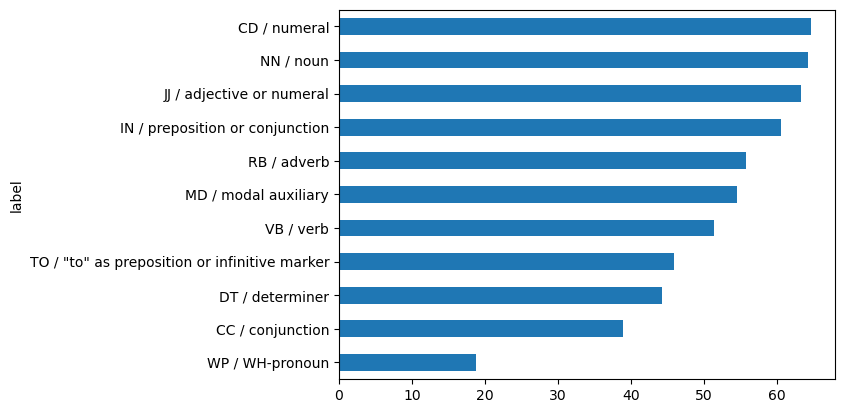

In [64]:
TEST_POS.reset_index().set_index('label').mean_i.sort_values().plot.barh();

## Add features to sentences

In [65]:
TEST['code'] = TEST.apply(lambda x: x.term_str + '/' + x.tag, axis=1) 
TEST_SENTENCES['code'] = TEST.groupby('sent_id').apply(lambda x: ' '.join(x.code))
TEST_SENTENCES['i_mean'] = TEST.groupby('sent_id').i.mean().round(2)
TEST_SENTENCES['pp'] = np.exp2(TEST_SENTENCES.i_mean)

In [66]:
TEST_SENTENCES.sort_values('pp')

,sent_str,code,i_mean,pp
sent_id,,,,
23,and a Miss Taylor in the house,and/CC a/DT miss/NN taylor/NN in/IN the/DT hou...,27.61,2.048510e+08
10,but the intercourse of the last seven years,but/CC the/DT intercourse/NN of/IN the/DT last...,30.86,1.948883e+09
15,interested in all its concerns,interested/JJ in/IN all/DT its/NN concerns/NN,32.10,4.603232e+09
27,but he was no companion for her,but/CC he/NN was/VB no/DT companion/NN for/IN ...,32.68,6.881138e+09
30,and Mr Woodhouse had not married early,and/CC mr/NN woodhouse/NN had/VB not/RB marrie...,32.92,8.126573e+09
22,only half a mile from them,only/RB half/JJ a/DT mile/NN from/IN them/NN,34.75,2.889298e+10
33,without activity of mind or body,without/IN activity/NN of/IN mind/NN or/CC bod...,34.87,3.139901e+10
24,and with all her advantages natural and domestic,and/CC with/IN all/DT her/NN advantages/NN nat...,36.31,8.519206e+10
19,How was she to bear the change,how/NN was/VB she/NN to/TO bear/VB the/DT chan...,37.30,1.692072e+11
